#### Teoría de Circuitos II
<img src="./logo_UTN.svg" align="right" width="150" /> 

# Filtros Digitales: Mitigación de Interferencias en el Electrocardiograma durante la Prueba de Esfuerzo 
#### Dr. Ing. Mariano Llamedo Soria
Grupo de Investigación en Bioingeniería (GIBIO)


### Introducción

<img src="./Recording-ECG.jpg" align="right" width="150" style="border:10px solid white" /> 


El electrocardiograma de superficie (ECG) es una medición no invasiva del potencial eléctrico producido por el dipolo eléctrico resultante en cada célula cardíaca. Por lo general, para la medición del ECG se colocan electrodos en las extremidades del cuerpo y sobre la superficie del torso, como se aprecia en la figura. Debido a que es una técnica no invasiva y su costo no es elevado, es ampliamente utilizada en la clínica médica para conocer la funcionalidad del corazón. Habitualmente se miden entre una y doce señales de ECG dependiendo de la patología bajo análisis.


<img src="./ergo_iss.jpg" align="left" width="350" style="border:10px solid white" /> 


La señal de ECG también es afectada por los campos eléctricos generados por todas las otras fuentes biológicas del organismo bajo estudio (ruido muscular), como también por otros factores como el movimiento de los electrodos sobre la piel y el acople de la línea eléctrica (50/60 Hz) entre otros. Una de las primeras tareas previas al análisis del ECG es el filtrado de interferencias. En el siguiente ejemplo, procederemos al filtrado de un ECG registrado durante una prueba de esfuerzo o ergometría. En dichos registros, las interferencias musculares son muy exageradas dado al esfuerzo físico al que es sometido el paciente.


Para tal fin, se procede a procesar la señal de ECG con diferentes filtros recursivos, o de respuesta infinita al impulso (IIR), como también filtros no recursivos, o de respuesta finita al impulso (FIR). Dichos filtros han sido presentados en clase, por lo que en el siguiente documento evaluaremos su desempeño de forma cualitativa en señales reales.

    

### Experimentación

Utilizaremos un registro de ECG proveniente de una prueba ergonométrica o de esfuerzo. El mismo ha sido digitalizado a una frecuencia de muestreo de 1000 Hz, y se encuentra guardado en el archivo *ecg.mat*.

Los filtros digitales pueden ser clasificados como recursivos o no recursivos, aunque en la asignatura lo hacemos dependiendo del soporte temporal de la respuesta al impulso. Es decir de respuesta finita (FIR) o infinita al impulso (IIR). Durante la primera parte de la asignatura, estudiamos diferentes aproximaciones a la respuesta ideal de un filtro, como la de Butterworth, Chebyshev y Bessel. En cada caso, logramos obtener una función matemática, es decir una función transferencia en el dominio de la frecuencia compleja $T(s)$, que luego se implementa mediante un circuito electrónico analógico. Luego hemos visto que $T(s)$ puede discretizarse, y en consecuencia modelar el comportamiento de un sistema digital, o muestreado a $T_S=1/f_S$ mediante la [transformada bilineal](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/filter_design/bilinear_transform.ipynb), es decir $s = 2 \, f_S \cdot \frac{z - 1}{z + 1}$

\begin{equation}
T(z) = T(s) \Big\vert_{s = 2 \,f_S \cdot \frac{z - 1}{z + 1}}
\end{equation}

Es decir, dada una sección de segundo orden (SOS) analógica

\begin{equation}
T(s) = \frac{\beta_0 + \beta_1 s + \beta_2 s^2}{\alpha_0 + \alpha_1 s + \alpha_2 s^2}
\end{equation}

su equivalente digital $T(z)$ también podrá expresarse como un cociente de polinomios en $z$, aunque como hemos visto, por razones de implementación lo haremos respecto a $z^{-1}$

\begin{equation}
T(z) = \frac{(\beta_2 K^2 - \beta_1 K + \beta_0) \, z^{-2} + (2 \beta_0 - 2 \beta_2 K^2) \,  z^{-1} + (\beta_2 K^2 + \beta_1 K + \beta_0)}
{(\alpha_2 K^2 - \alpha_1 K + \alpha_0) \, z^{-2} + (2 \alpha_0 - 2 \alpha_2 K^2) \,  z^{-1} + (\alpha_2 K^2 + \alpha_1 K + \alpha_0)}
\end{equation}
donde $K = 2f_S$.

Para luego reescribir $T(z)$ en función de los coeficientes del sistema muestreado $b_m$ y $a_n$

\begin{equation}
T(z) = \frac{Y(z)}{X(z)} = \frac{ b_2 \, z^{-2} + b_1 \,  z^{-1} + b_0 }
{a_2 \, z^{-2} + a_1 \,  z^{-1} + a_0}
\end{equation}

obteniendo también una SOS como era de esperar, dado que la transformada bilineal es una transformación conforme. Una vez obtenida nuestra $T(z)$ de orden arbitrario, solo resta partir la transferencia en subsecciones de segundo orden (SOS). Para ello, es necesario conocer tanto la [estructura](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/recursive_filters/direct_forms.ipynb) como la forma en que nuestro paquete de software implementa las [SOS's](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/recursive_filters/cascaded_structures.ipynb)
e. En el caso de *SciPy*, cuenta con una familia de funciones donde es muy sencillo diseñar y utilizar filtros digitales implementados como SOS's, como se verá en la implementación.

Para llegar a la implementación de nuestro filtro digital $T(z)$, se despeja $Y(z)$

\begin{equation}
Y(z) =  \frac{1}{a_0} \left( \sum_{m=0}^{M} b_m \, X(z) \, z^{-m} - \sum_{n=1}^{N} a_n \, Y(z) \, z^{-n} \right)
\end{equation}

finalmente se obtiene $y[k]$ por simple inspección sabiendo que $y[k-m] = Y(z) \, z^{-m}$

\begin{equation}
y[k] = \frac{1}{a_0} \left( \sum_{m=0}^{M} b_m \; x[k-m] - \sum_{n=1}^{N} a_n \; y[k-n] \right) \label{eq:ec_dif}
\end{equation}

Esta ecuación nos permite conocer el valor de la salida actual, y se la conoce como *ecuación de diferencias*. Esta misma ecuación es lo suficientemente general para la implementación de filtros IIR, como también de los FIR. Basta con hacer $a_n = 0$ para que la ec. \eqref{eq:ec_dif} se convierta en la convolución discreta entre $x[k]$ y la respuesta al impulso finita, dada por $b[m]=(b_0, b_1, \cdots, b_M)$. Los coeficientes $b_m$ del filtro FIR, pueden calcularse por ejemplo, mediante el [método de ventanas](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/filter_design/window_method.ipynb), entre [otros](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/filter_design/frequency_sampling_method.ipynb).

Como se trata de un análisis *offline* utilizando una arquitectura computacional sin limitaciones numéricas, como las provistas por las librerías SciPy y NumPy, algunos problemas relacionados a la implementación con aritmética y palabras de cuantización finitas no son tenidos en cuenta. Se refiere a los estudiantes interesados a los siguientes documentos acerca de [errores por la quantización de coeficientes](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/recursive_filters/quantization_of_coefficients.ipynb) y por una unidades aritméticas limitadas [(1, ](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/recursive_filters/quantization_of_variables.ipynb) [2)](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/nonrecursive_filters/quantization_effects.ipynb). También se le recomienda a los estudiantes interesados revisar las asignaturas optativas relacionadas al [Procesamiento Digital de Señales (DSP)](https://aulasvirtuales.frba.utn.edu.ar/course/view.php?id=9591).

En principio procedemos a diseñar los filtros mediante el siguiente script. Se comienza por la inicialización de los módulos a utilizar:

In [1]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

fig_sz_x = 25
fig_sz_y = 10
fig_dpi = 80 # dpi

fig_font_family = 'Ubuntu'
fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})
plt.rcParams.update({'font.family':fig_font_family})


Para luego continuar concretamente con la carga de la señal de ECG registrada durante una prueba de esfuerzo, a una frecuencia de muestreo de 1 kHz.

In [2]:
#Diseño de los filtros digitales

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000 # Hz
nyq_frec = fs / 2



Se define la plantilla de los filtros digitales en base al conocimiento previo de la naturaleza de la señal de ECG (ancho de banda aproximado de 0.5 a 35 Hz) y las interferencias que se mencionaron en la introducción.

In [3]:

# filter design
ripple = 0.5 # dB
atenuacion = 40 # dB

ws1 = 0.1 #Hz
wp1 = 1.0 #Hz
wp2 = 35.0 #Hz
ws2 = 45.0 #Hz

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)


bp_sos_butter = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=0.5, gstop=40., analog=False, ftype='butter', output='sos')
bp_sos_cheby = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=0.5, gstop=40., analog=False, ftype='cheby1', output='sos')
bp_sos_cauer = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=0.5, gstop=40., analog=False, ftype='ellip', output='sos')

cant_coef = 501

#num_firls = sig.firls(cant_coef, frecs, gains, fs=fs)
#num_remez = sig.remez(cant_coef, frecs, gains[::2], fs=fs)
num_win =   sig.firwin2(cant_coef, frecs, gains , window='blackmanharris' )

den = 1.0


Una vez diseñados los filtros procedemos a analizarlos

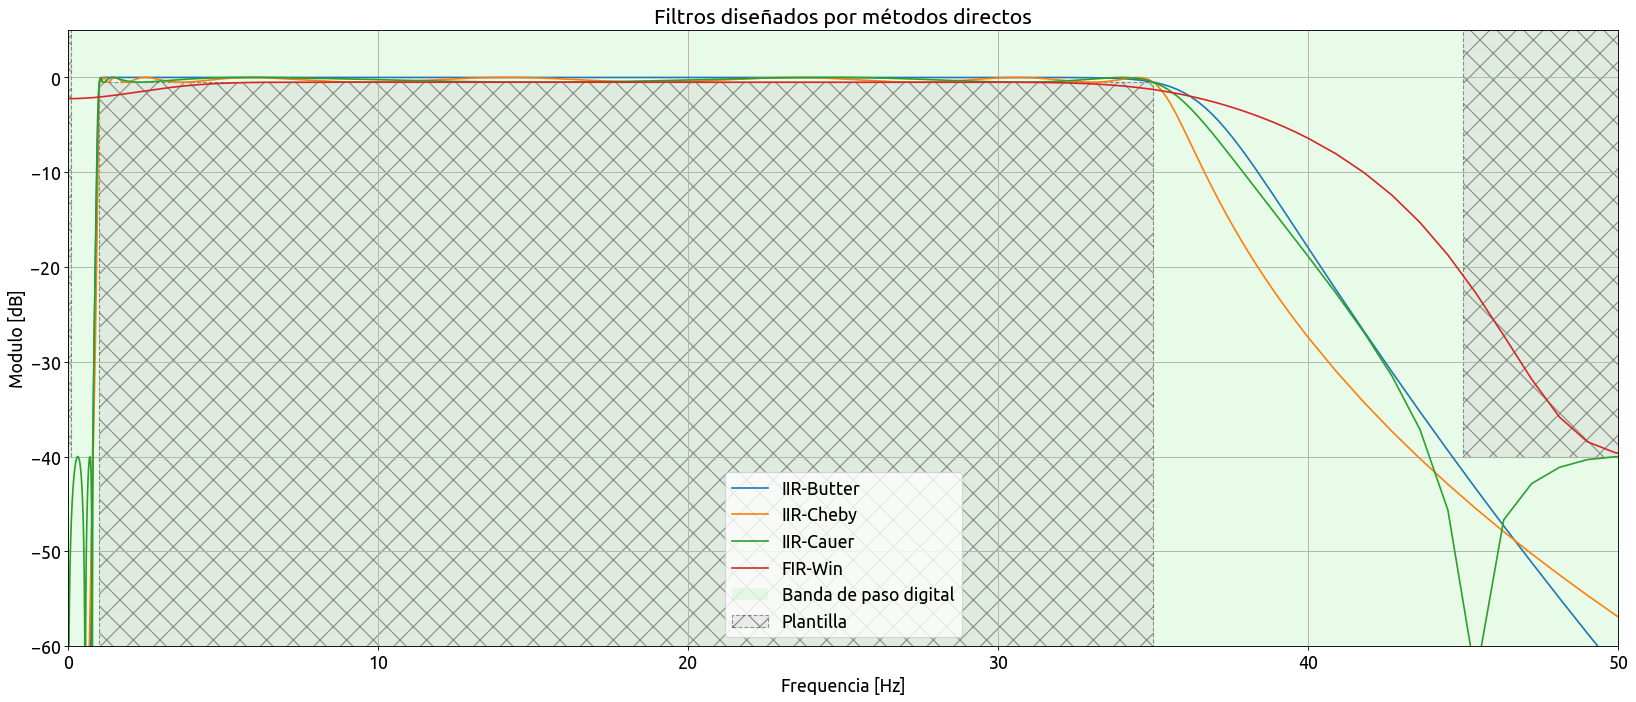

In [4]:

plt.rcParams.update({'font.size':fig_font_size})
plt.rcParams.update({'font.family':fig_font_family})

NN = 1024
w_rad  = np.append(np.logspace(-2, 0.8, NN//4), np.logspace(0.9, 1.6, NN//4) )
w_rad  = np.append(w_rad, np.linspace(40, nyq_frec, NN//2, endpoint=True) ) / nyq_frec * np.pi

w, h_butter = sig.sosfreqz(bp_sos_butter, worN=w_rad)
_, h_cheby = sig.sosfreqz(bp_sos_cheby, worN=w_rad)
_, h_cauer = sig.sosfreqz(bp_sos_cauer, worN=w_rad)
#_, hh_firls = sig.freqz(num_firls, den, worN=w_rad)
#_, hh_remez = sig.freqz(num_remez, den, worN=w_rad)
_, hh_win = sig.freqz(num_win, den, worN=w_rad)

w = w / np.pi * nyq_frec

def respuesta_filtro(this_title):

    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    
    plt.plot(w, 20*np.log10(np.abs(h_butter)), label='IIR-Butter' )
    plt.plot(w, 20*np.log10(np.abs(h_cheby)), label='IIR-Cheby' )
    plt.plot(w, 20*np.log10(np.abs(h_cauer)), label='IIR-Cauer' )
    #plt.plot(w, 20 * np.log10(abs(hh_firls)), label='FIR-ls')
    #plt.plot(w, 20 * np.log10(abs(hh_remez)), label='FIR-remez')
    plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win')
    
    plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)
    
    plt.title(this_title)
    plt.xlabel('Frequencia [Hz]')
    plt.ylabel('Modulo [dB]')
    plt.gca().legend()
    plt.grid()
    plt.axis([0, 50, -60, 5 ]);
    

respuesta_filtro('Filtros diseñados por métodos directos')
plt.show()



Mirando más en detalle la plantilla en el corte inferior y superior del filtro, notamos algunas dificultades en los algoritmos de diseño.

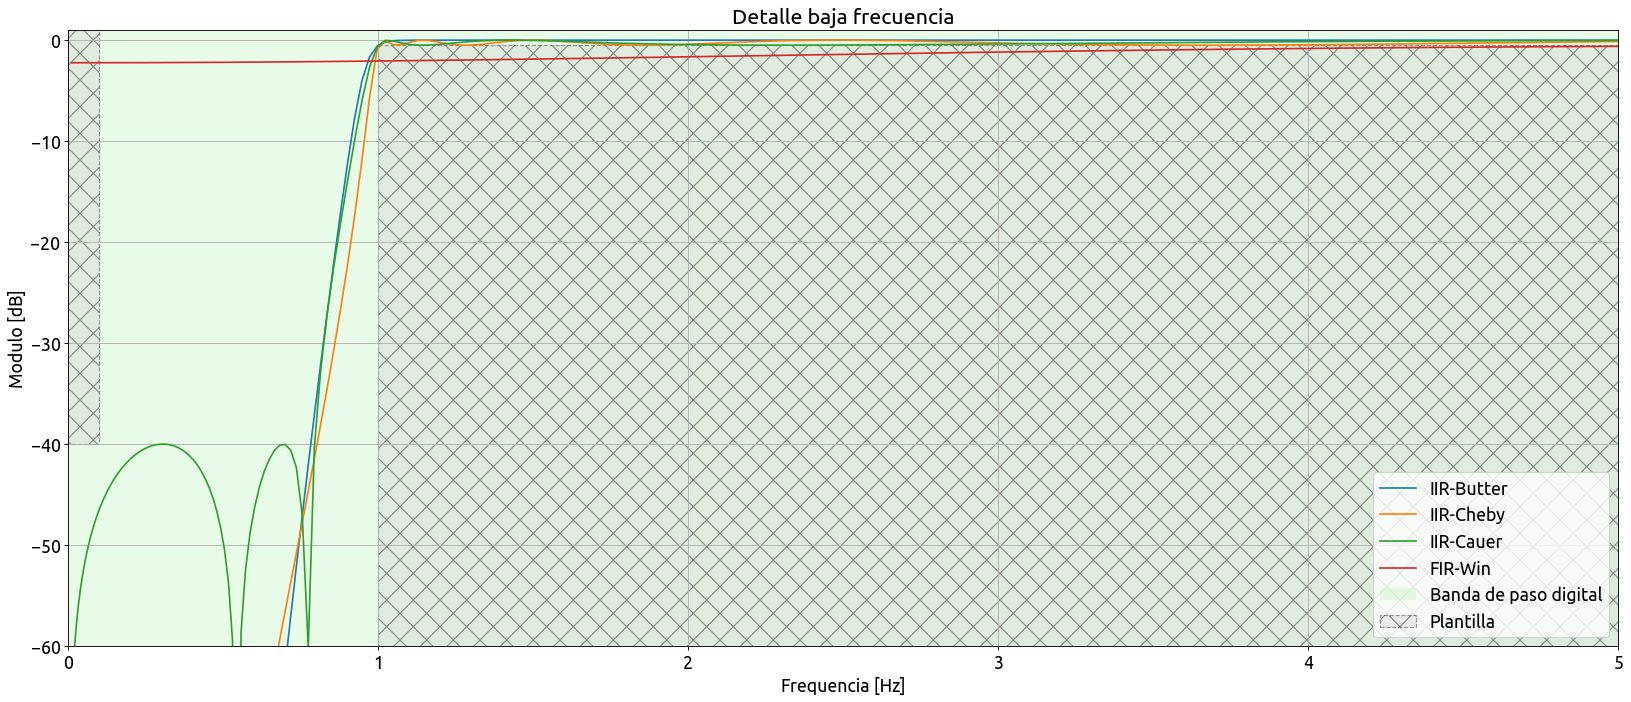

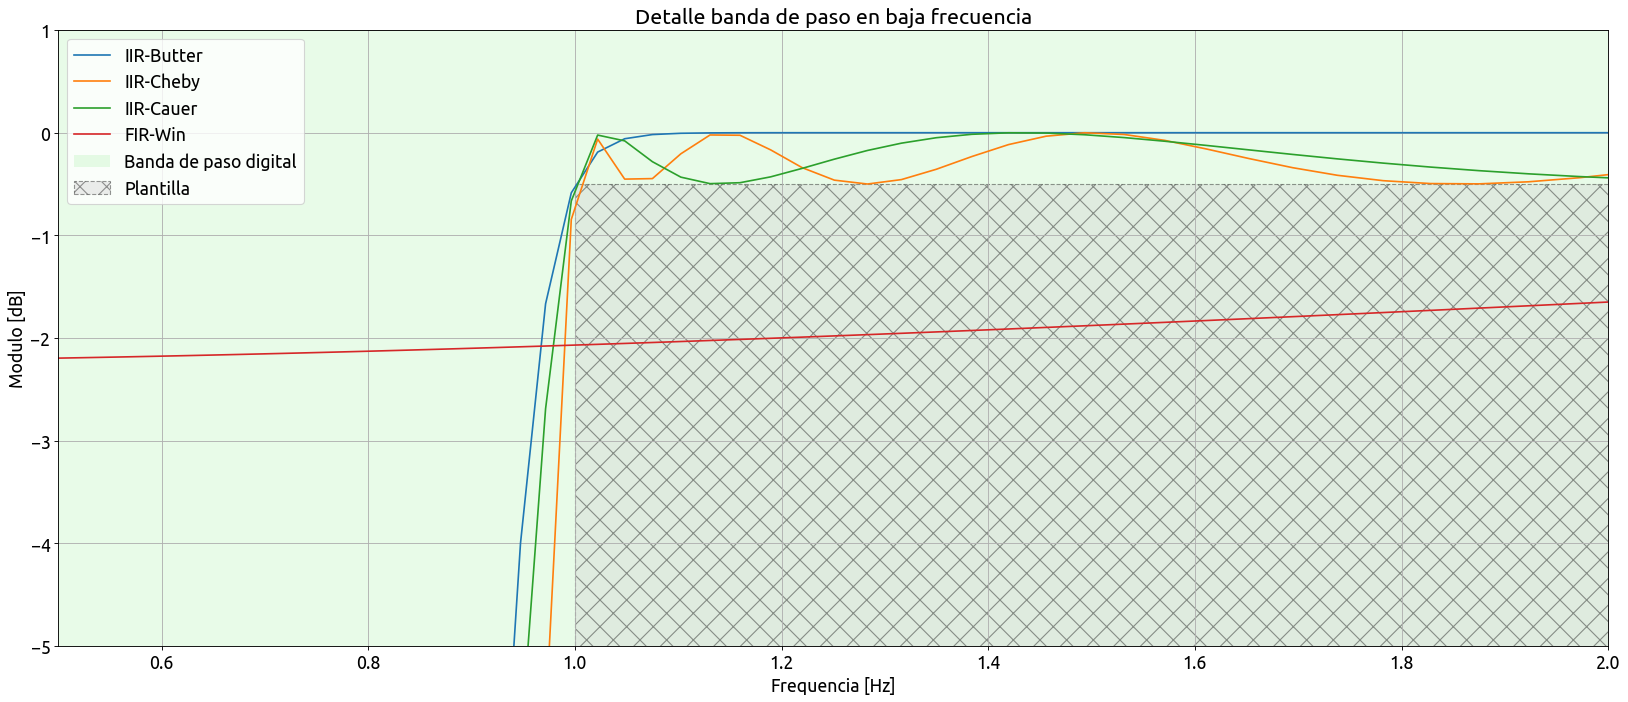

In [5]:
    

respuesta_filtro('Detalle baja frecuencia')
plt.axis([0, 5, -60, 1 ]);
plt.show()

respuesta_filtro('Detalle banda de paso en baja frecuencia')
plt.axis([0.5, 2, -5, 1 ]);
plt.show()


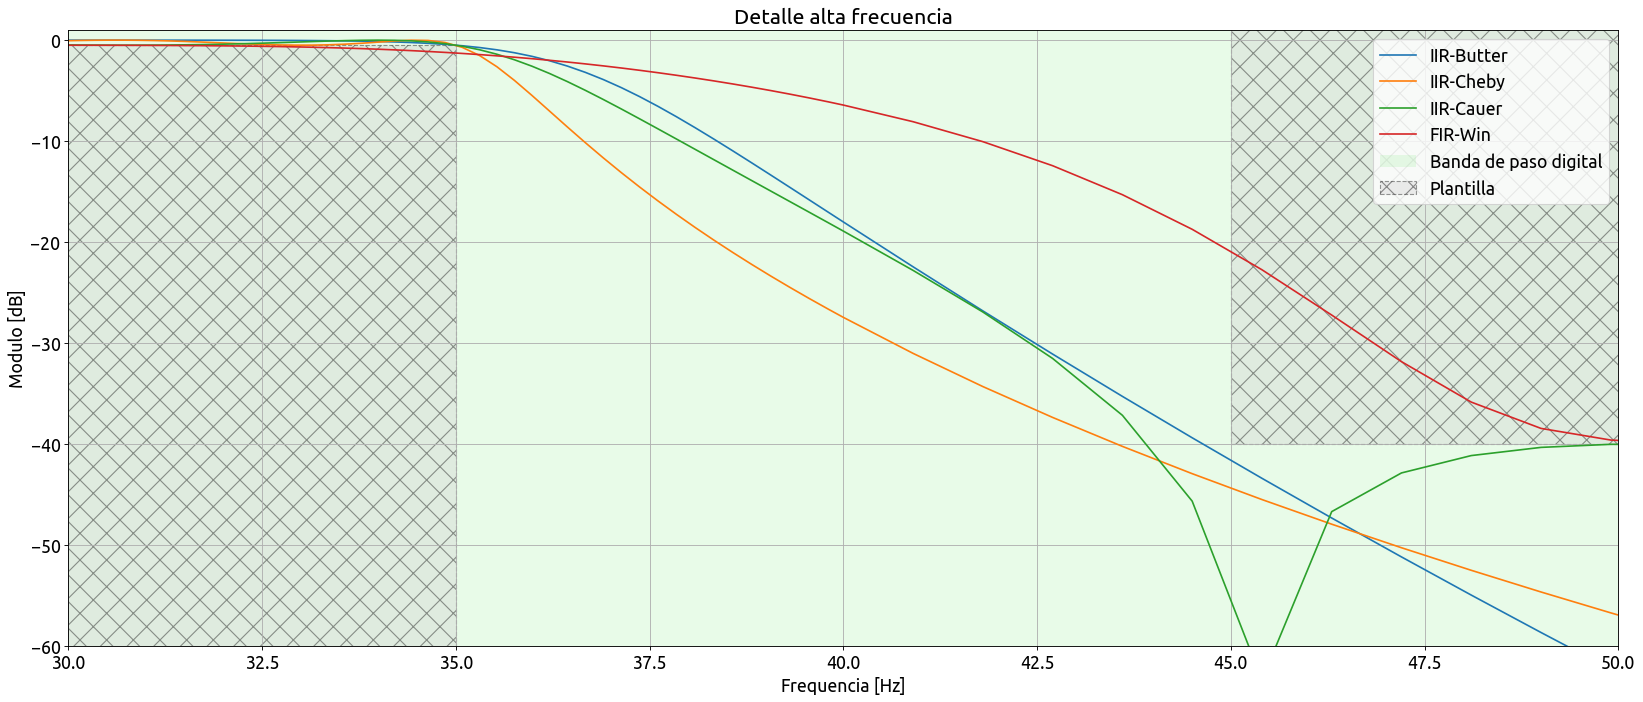

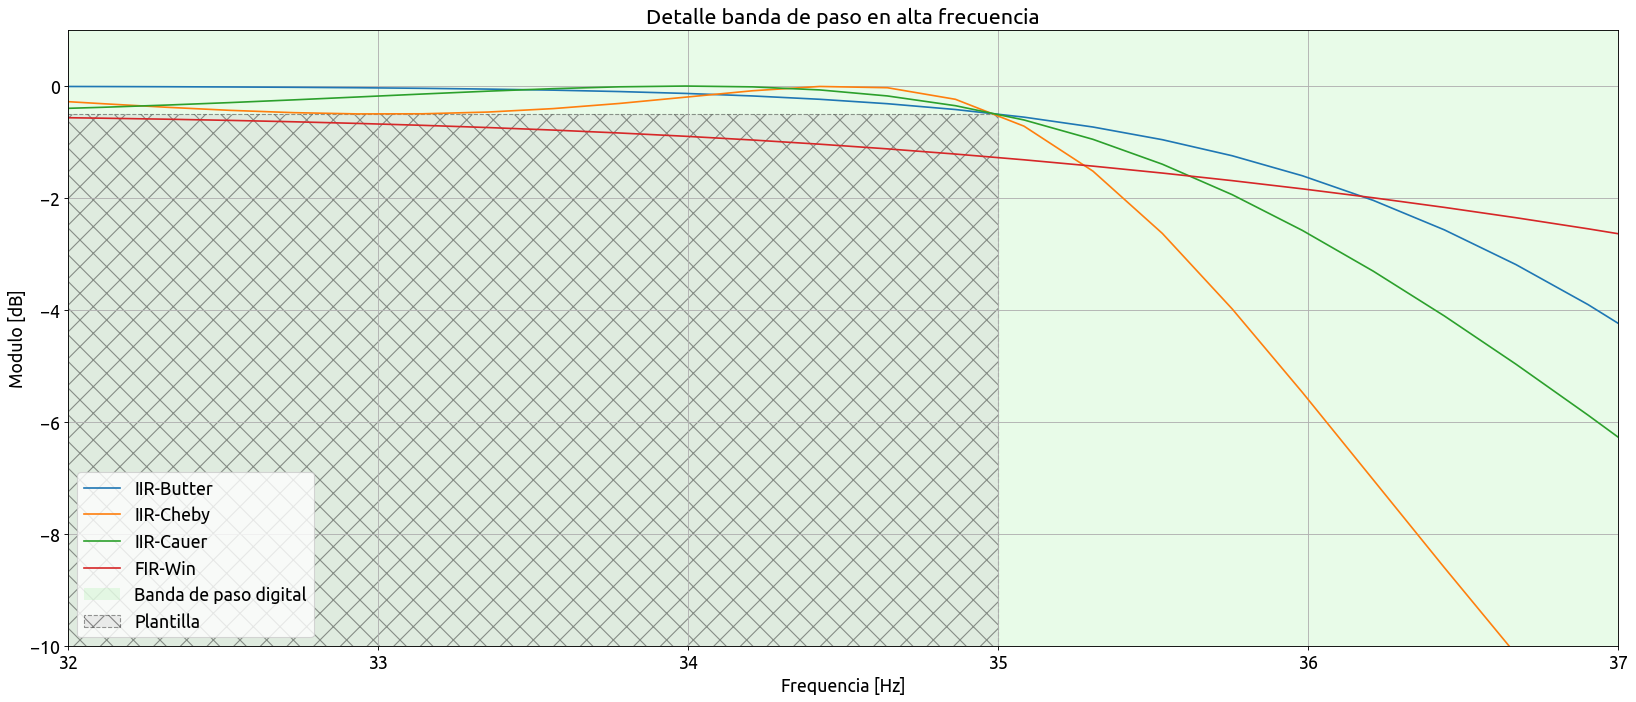

In [6]:
respuesta_filtro('Detalle alta frecuencia')
plt.axis([30, 50, -60, 1 ]);
plt.show()

respuesta_filtro('Detalle banda de paso en alta frecuencia')
plt.axis([32, 37, -10, 1 ]);
plt.show()


Como se suele mencionar en clase, las rutinas de diseño de los filtros IIR son mucho más poderosas y fáciles de usar que las de los FIR. Nótese que todos los filtros IIR cumplen con la plantilla de diseño en la primera iteración. Para aprovechar los beneficios de los filtros FIR, llegar a un diseño exitoso requiere varias iteraciones y algo de  astucia utilizando las funciones provistas. Se sugiere a quienes tengan interés en el diseño de filtros FIR explorar las funciones más sofisticadas incluidas [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html#filter-design):

* [Método de ventanas](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin2.html)
* [Cuadrados mínimos](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firls.html)
* [Método de Remez ó equirripple](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.remez.html)
* [Filtros FIR de Savitzky-Golay](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_coeffs.html)

Finalmente utilizaremos los filtros diseñados mediante las funciones que implementan la [ecuación de diferencias (lfilter)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html) (ec. \eqref{eq:ec_dif}) y sus funciones de inicialización ([lfilter_zi](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter_zi.html)). Para este notebook, utilizaremos las funciones de [filtrado bidireccional (filtfilt)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html) dado que al cancelar la fase introducida por el filtro digital, permite sincronizar la señal de entrada y salida al filtro para facilitar la visualización. A continuación se da una breve explicación teórica del método.


### Filtrado bidireccional
El filtrado bidireccional es una técnica sumamente conveniente al momento de filtrar digitalmente una señal, dado que evita por completo cualquier distorsión de fase. Esto afecta principalmente a los filtros IIR, donde las distorsiones pueden ser notorias. Sin embargo, los filtros FIR cuya respuesta al impulso sea simétrica (par o simpar), **no** producen distorsión de fase debido a que su fase **es lineal**. 

En ambos casos, tanto para los IIR como para los FIR, simétricos o no, el resultado es una anulación completa de la respuesta de fase, obteniéndose así un **filtro de fase cero**. Recordemos que la transformada de Fourier de la inversión en tiempo es 

\begin{equation}
x[-k] \stackrel{\mathrm{DFT}}{\longleftrightarrow} X^*(e^{j \, \Omega })
\end{equation}

Por lo tanto, vemos que la inversión en tiempo conlleva la negación de la respuesta de fase de una señal. Entonces utilizaremos una doble inversión temporal para cancelar los efectos de fase, y al mismo tiempo el resultado neto sobre la señal espejada dos veces será nulo

\begin{equation}
Y(e^{j \, \Omega }) = X(e^{j \, \Omega }) \cdot T^*(e^{j \, \Omega }) \cdot T(e^{j \, \Omega }) 
\end{equation}

\begin{equation}
Y = X \cdot |T|^2
\end{equation}

*(Se simplificó la notación para clarificar el resultado)* Se observa como resultado de aplicar el método bidireccional un filtro equivalente al cuadrado del módulo y con aporte nulo de fase para todas las frecuencias. Esto equivale a haber atravesado dos veces por el mismo filtro, por lo tanto la atenuación será el doble que la del filtro original (y el *ripple* en banda también!) razón por lo cual debe modificarse la plantilla de diseño relajando a la mitad la atenuación y el ripple. 

Ahora se procede a la aplicación de los filtros digitales diseñados y se analiza qué tan bien funcionan los filtros. Recordar que el análisis cualitativo que se realizará se centra en:

* la **efectividad** del filtro, al atenuar la energía de las señales interferentes, y
* la **inocuidad**, al **NO** distorsionar la información que contiene la envolvente de la señal de ECG.

esto es lo **mínimo** que se puede esperar de un filtro correctamente diseñado. Comenzamos con el análisis de la efectividad, analizando zonas con mucha interferencia.

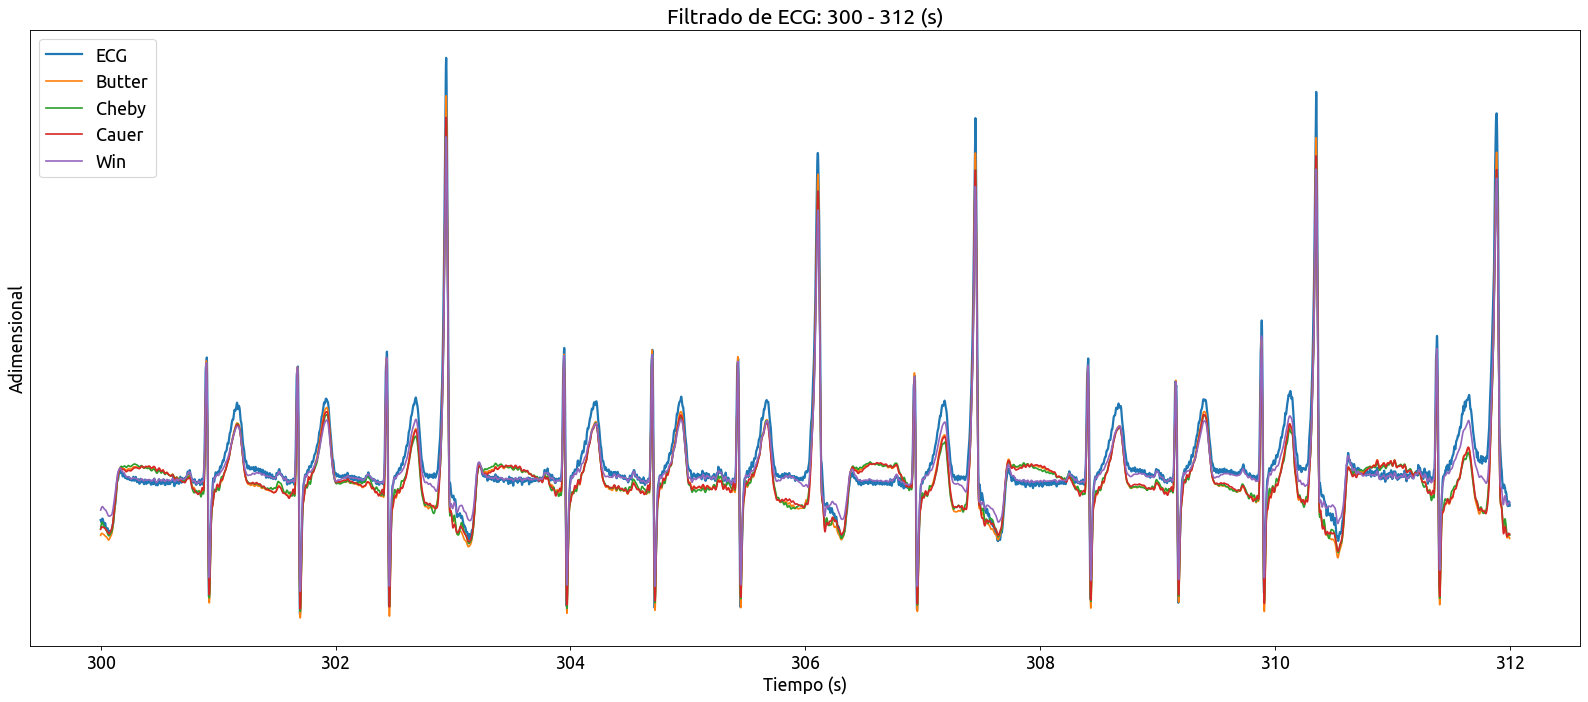

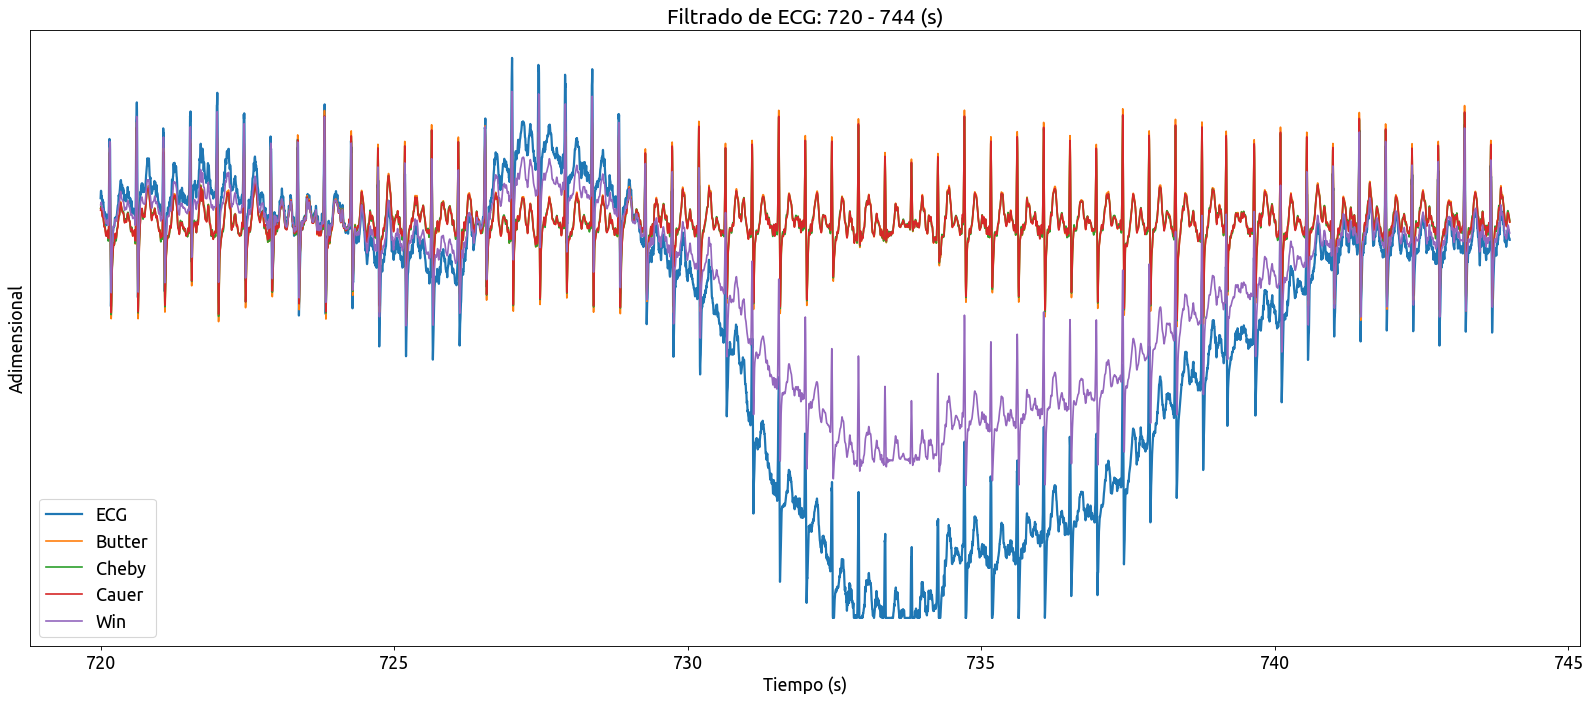

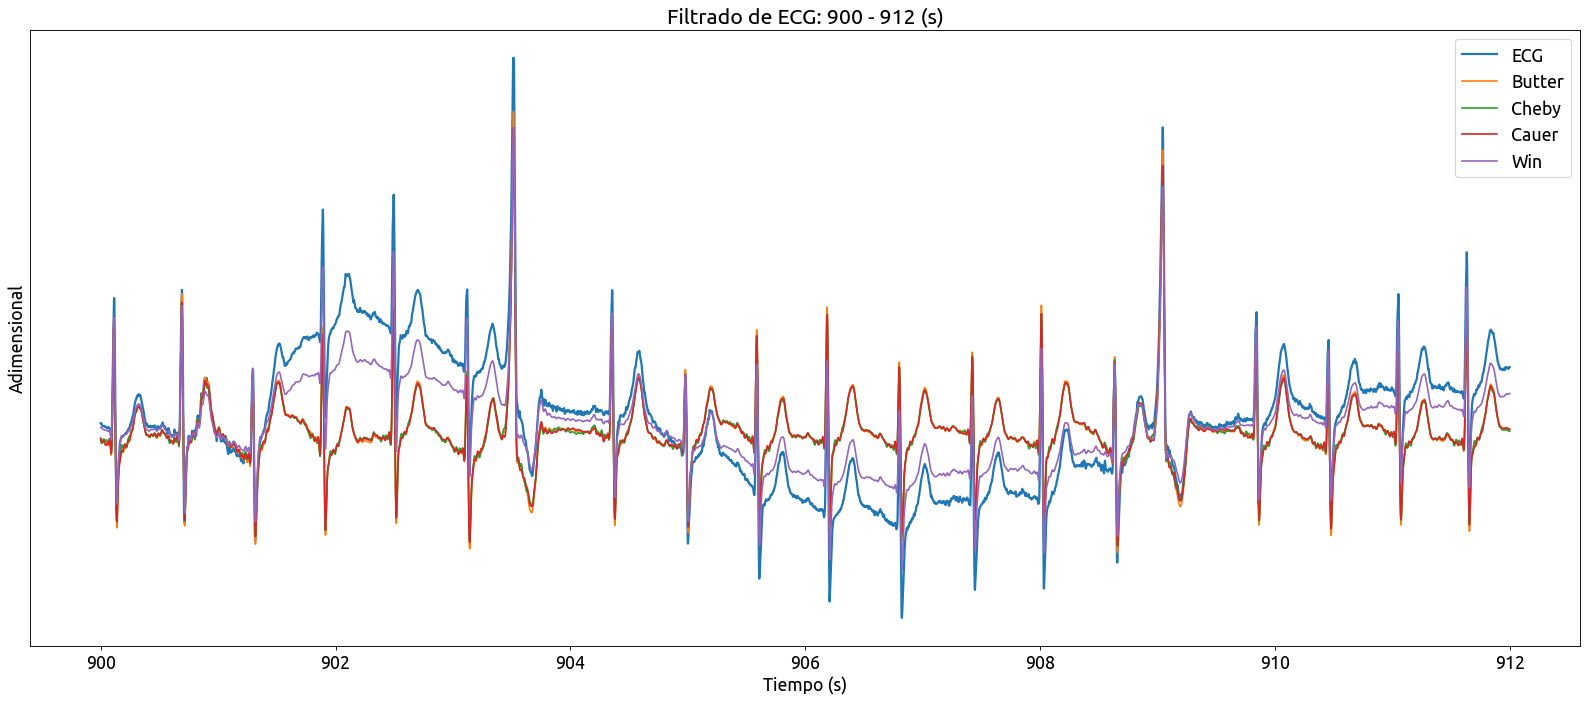

In [7]:
# Procedemos al filtrado
ECG_f_butt = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)
ECG_f_cheb = sig.sosfiltfilt(bp_sos_cheby, ecg_one_lead)
ECG_f_cauer = sig.sosfiltfilt(bp_sos_cauer, ecg_one_lead)

#ECG_f_ls = sig.filtfilt(num_firls, den, ecg_one_lead)
#ECG_f_remez = sig.filtfilt(num_remez, den, ecg_one_lead)
ECG_f_win = sig.filtfilt(num_win, den, ecg_one_lead)

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

fig_sz_x = 25
fig_sz_y = 10

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region/fs, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region/fs, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region/fs, ECG_f_cheb[zoom_region], label='Cheby')
    plt.plot(zoom_region/fs, ECG_f_cauer[zoom_region], label='Cauer')
    #plt.plot(zoom_region, ECG_f_remez[zoom_region], label='Remez')
    #plt.plot(zoom_region, ECG_f_ls[zoom_region], label='LS')
    plt.plot(zoom_region/fs, ECG_f_win[zoom_region], label='Win')
    
    plt.title('Filtrado de ECG: {:3.0f} - {:3.0f} (s)'.format(ii[0]/fs, ii[1]/fs) )
    plt.ylabel('Adimensional')
    plt.xlabel('Tiempo (s)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Al analizar el efecto del filtrado, observamos que la señal original de ECG (en azul) posee contaminación de baja frecuencia en algunas zonas del registro. Dicha contaminación probablemente se deba al aumento de la actividad física durante la prueba de esfuerzo. Como se observa, la mayor parte de las técnicas de filtrados es inocua cuando no hay contaminación de baja frecuencia, y remueve los movimientos de la línea de base correctamente. Sin embargo, algunos filtros, como los FIR diseñados por el método de ventana, no son capaces de eliminar por completo la interferencia a pesar de su elevado orden, como se aprecia en la señal violeta en el segundo panel.

Ahora analizaremos cómo se han comportado los filtros analizando la señal en detalle para algunos latidos específicos. Desde luego nos interesará que la señal de ECG no haya sido alterada en su morfología, debido a que esto podría imposibilitar su uso como método de diagnóstico. 

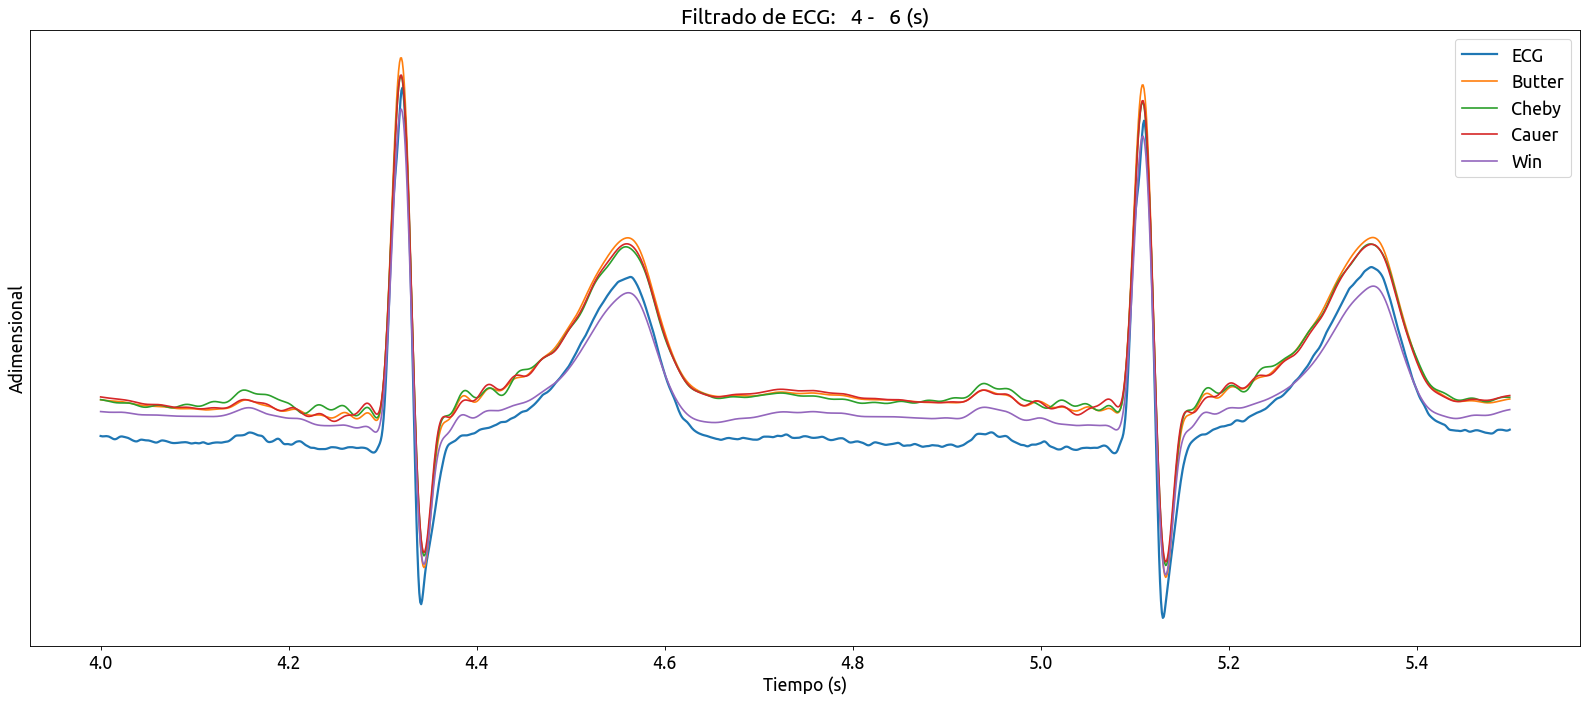

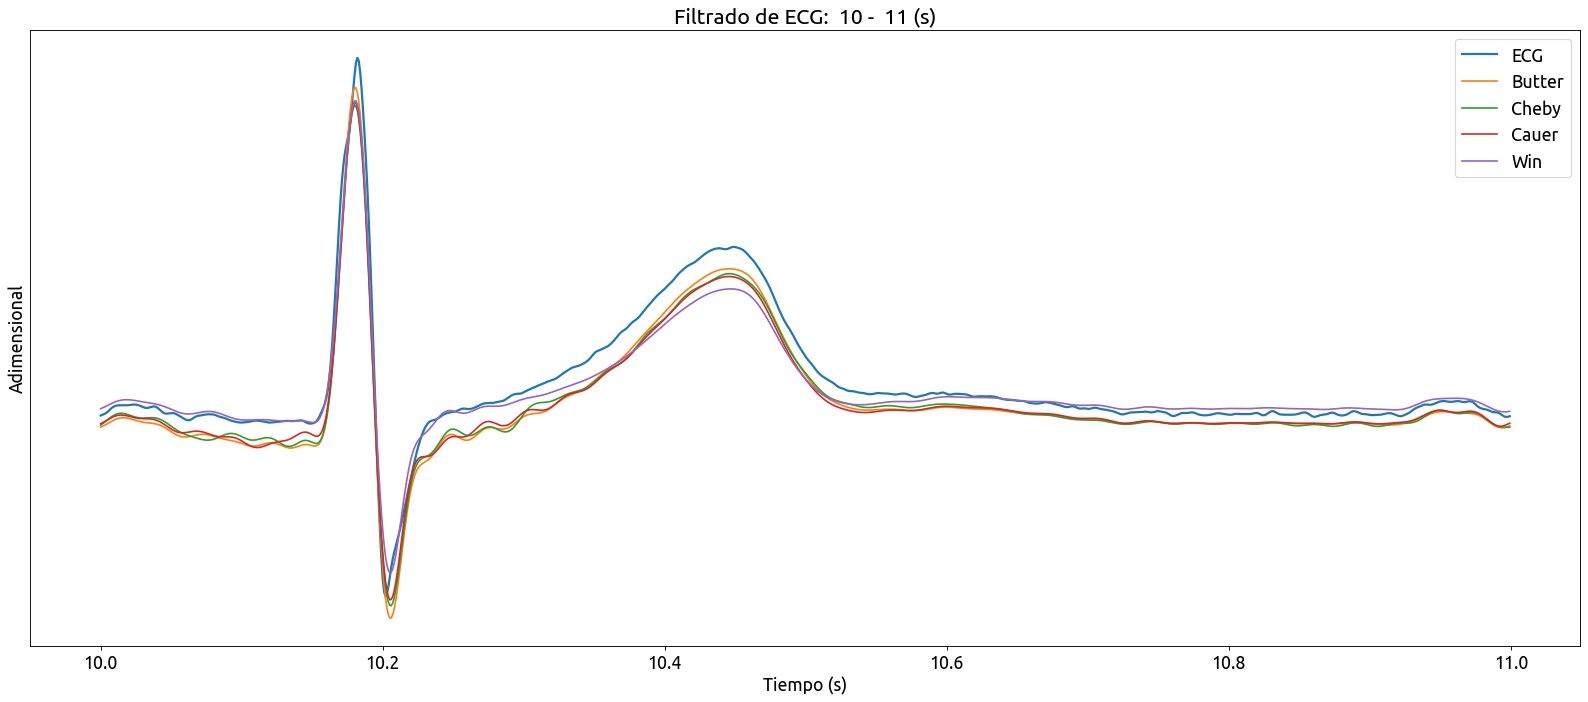

In [8]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region/fs, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region/fs, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region/fs, ECG_f_cheb[zoom_region], label='Cheby')
    plt.plot(zoom_region/fs, ECG_f_cauer[zoom_region], label='Cauer')
    #plt.plot(zoom_region, ECG_f_remez[zoom_region], label='Remez')
    #plt.plot(zoom_region, ECG_f_ls[zoom_region], label='LS')
    plt.plot(zoom_region/fs, ECG_f_win[zoom_region], label='Win')
    
    plt.title('Filtrado de ECG: {:3.0f} - {:3.0f} (s)'.format(ii[0]/fs, ii[1]/fs) )
    plt.ylabel('Adimensional')
    plt.xlabel('Tiempo (s)')
    
    axes_hdl = plt.gca()
    axes_hdl.set_yticks(())
    axes_hdl.legend()
            
    plt.show()

Como se observa, la señal de ECG ha sido alterada en su morfología. El complejo de ondas QRS, es decir las primeras deflecciones rápidas de mayor energía relacionadas con la compresión muscular, han sido claramente atenuadas, mientras que la onda T, la segunda onda positiva de mayor duración y relacionada con la relajación muscular, ha sido también atenuada. También se observan otros artefactos ocasionados por el filtrado lineal, como oscilaciones que no estaban presentes en el ECG original. Estas observaciones dan cuenta, que estos filtros no son adecuados para esta tarea y es necesario su rediseño teniendo en cuenta estos aspectos.